# Hello, this my first time using TF

### Goals:
- Implement a DNN with TF

##### Note that this implementation is heavily inspired from courses from Arthur Douillard: https://m2dsupsdlclass.github.io/lectures-labs/

In [1]:
import tensorflow as tf
import numpy as np

In [9]:
def init_weights(shape, stddev=0.01, mean=0):
    return tf.Variable(tf.random.normal(shape, stddev=stddev, mean=mean))

def apply_activation(activation, z_n):
    dic = {
        "relu": tf.nn.relu,
        "sigmoid": tf.nn.sigmoid,
        "softmax": tf.nn.softmax,
        "tanh": tf.math.tanh,
        "linear": tf.keras.activations.linear
        # Add more of your functions if you need
    }
    
    return dic[activation](z_n) # Put your parameters if needed

def accuracy(y_pred, y):
    return np.mean(np.argmax(y_pred, axis=1) == y)


def test_model(model, x, y):
    dataset = gen_dataset(x, y)
    preds, targets = [], []
    
    for batch_x, batch_y in dataset:
        preds.append(model(batch_x).numpy())
        targets.append(batch_y.numpy())
     
    preds, targets = np.concatenate(preds), np.concatenate(targets)
    return accuracy(preds, targets)

In [10]:
class L_Layer_Model:
    # We consider layer to be [input, h1, h2, h3, ..., output]
    def __init__(self, layers, activations):
        values = [] 
        for i in range(1, len(layers)):
            values.append(init_weights((layers[i - 1], layers[i])))
            values.append(init_weights([layers[i]]))
        self.values = values
        self.activations = activations
        
    def __call__(self, inputs):
        if len(self.values) == 0:
            raise Exception("0 Layer Model?")
        z1 = tf.matmul(inputs, self.values[0]) + self.values[1]
        a1 = apply_activation(self.activations[0], z1)
        idx = 2
        # Leaving the activation of the last layer for tf functions
        for i in range(2, len(layers) - 1):
            z1 = tf.matmul(a1, self.values[idx]) + self.values[idx + 1]
            a1 = apply_activation(self.activations[i - 1], z1)
            idx += 2
        return tf.matmul(a1, self.values[idx] + self.values[idx + 1])

#### Let's test this !

Text(0.5, 1.0, 'Image Label: 0')

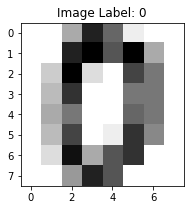

In [11]:
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt

digits = load_digits()

sample_idx = 0

plt.figure(figsize=(3,3))
plt.imshow(digits.images[sample_idx], cmap=plt.cm.gray_r,
          interpolation='nearest')

plt.title(f"Image Label: {digits.target[sample_idx]}")

#### Preprocessing
- Normalize
- Train Test Split

In [12]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

data = np.asarray(digits.data, dtype='float32')
target = np.asarray(digits.target, dtype='int32')

X_train, X_test, y_train, y_test = train_test_split(data, target,
                                                    test_size=0.15,
                                                   random_state=37)
# We put a random state to have reproducible results

scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train) # Center and normalize
X_test = scaler.fit_transform(X_test)

(X_train.shape, y_train.shape), (X_test.shape, y_test.shape)

(((1527, 64), (1527,)), ((270, 64), (270,)))

In [13]:
def gen_dataset(x, y, batch_size=128):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.shuffle(buffer_size=10000, seed=42)
    dataset = dataset.batch(batch_size=batch_size)
    
    return dataset

In [14]:
from tensorflow.keras import optimizers # Get optimizers

In [15]:
layers = [X_train.shape[1], 15, 10]
# Linear in the output because it will go into the softmax
activations_list = [["sigmoid"],
                   ["relu"],
                   ["tanh"]]
# Set 15 as hidden layer size
# 10 is because we have 10 classes (digits)

# Hyperparameters
num_epochs = 15 # How long the model should be trained
batch_size = 32
learning_rate = 0.1
# Basic optimizer, up to you, I'll use the nesterov one
optimizer = optimizers.SGD(learning_rate = learning_rate,
                          momentum = 0.9,
                          nesterov=True)
for activations in activations_list:
    model = L_Layer_Model(layers, activations)
    print("Activations: ", activations)
    print(f"Without Training: {test_model(model, X_train, y_train)}")
    for e in range(num_epochs):

        train_dataset = gen_dataset(X_train, y_train, batch_size)

        for batch_x, batch_y in train_dataset:
            with tf.GradientTape() as tape:
                logits = model(batch_x)
                loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(batch_y, logits))
            grads = tape.gradient(loss, model.values)
            optimizer.apply_gradients(zip(grads, model.values),
                                    experimental_aggregate_gradients=True)

        train_accuracy = test_model(model, X_train, y_train)
        test_accuracy = test_model(model, X_test, y_test)

        print(f"Epoch {e}, train_acc = {round(train_accuracy, 4)}, test_acc = {round(test_accuracy, 4)}")
        
    print()

Activations:  ['sigmoid']
Without Training: 0.10216110019646366
Epoch 0, train_acc = 0.2508, test_acc = 0.3
Epoch 1, train_acc = 0.8585, test_acc = 0.863
Epoch 2, train_acc = 0.9391, test_acc = 0.9481
Epoch 3, train_acc = 0.9673, test_acc = 0.9519
Epoch 4, train_acc = 0.9777, test_acc = 0.9556
Epoch 5, train_acc = 0.979, test_acc = 0.9593
Epoch 6, train_acc = 0.9849, test_acc = 0.9593
Epoch 7, train_acc = 0.9862, test_acc = 0.9593
Epoch 8, train_acc = 0.9895, test_acc = 0.9556
Epoch 9, train_acc = 0.9895, test_acc = 0.9519
Epoch 10, train_acc = 0.9908, test_acc = 0.9556
Epoch 11, train_acc = 0.9915, test_acc = 0.963
Epoch 12, train_acc = 0.9935, test_acc = 0.9593
Epoch 13, train_acc = 0.9948, test_acc = 0.963
Epoch 14, train_acc = 0.9961, test_acc = 0.963

Activations:  ['relu']
Without Training: 0.09757694826457106
Epoch 0, train_acc = 0.4538, test_acc = 0.4407
Epoch 1, train_acc = 0.6509, test_acc = 0.6296
Epoch 2, train_acc = 0.9463, test_acc = 0.9222
Epoch 3, train_acc = 0.9509, te